In [45]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import seaborn as sns
import scipy


# Økonometri A



## Problem Set 7



### Hedonic price regressions



In this problem set, we examine if there is heteroskedasticity in the hedonic price model and implement methods to correct for it. If heteroskedasticity is present, the variance of the error terms is different across observations and conventional $t$ and $F$ tests are invalid.

For the analysis, we use graphical and formal tests of heteroskedasticity and implement the method of Weighted Least Squares (WLS) that estimates the model parameters efficiently.

In problem set 6, one of the hedonic price models we worked with was:

$$
\log(\text{price}_i) = \beta_0 + \delta_1 \text{KbhK}_i + \delta_2 \text{KbhN}_i + \delta_3 \text{KbhV}_i + \beta_1 \text{m2}_i + \beta_2 \text{m2}^2_i + \beta_3 \text{rooms}_i + \beta_4 \text{toilets}_i + u_i \tag{1}
$$

We will examine a modified version of the model, where the dependent variable is price measured in DKK (without taking the log):

$$
\text{price}_i = \beta_0 + \delta_1 \text{KbhK}_i + \delta_2 \text{KbhN}_i + \delta_3 \text{KbhV}_i + \beta_1 \text{m2}_i + \beta_2 \text{m2}^2_i + \beta_3 \text{rooms}_i + \beta_4 \text{toilets}_i + u_i \tag{2}
$$

The problem of heteroskedasticity may in some cases be reduced — and even removed — by taking the log of the dependent variable. This was one motivation for estimating model (1) in the previous problem set. In problem set 7, we start by analyzing model (2) to see if it indeed suffers from heteroskedasticity.



### Group work



Discuss the following questions in groups.



#### Task 1. 

Suppose that assumption MLR.5 **does not** hold for model (2). What does this mean for the properties of the OLS estimator?


**Your answer:**

Variansen afhænger af x, så den er forskellig for forskellige observationer. Dermed bliver t, og F-test ubruelige. (Heteroskedacitet)


#### Task 2. 
Suppose that apartment size, $m2_i$, affects the variance of the error term and is thus a relevant scale variable driving the heteroskedasticity. Provide an economic argument for why the variance of the error terms may depend on apartment size. Explain how it is possible for the error terms to satisfy MLR.4, but not MLR.5.


**Your answer:**

1) En lille lejlighed kan ligge et godt sted og være rigtig dyr, men kan også ligge et dårligt sted og være rigtig billig, gælder også for store lejligheder, derfor varierer prisen altså meget. 
2) Middelværdien af fejledet kan snildt være 0(MLR.4), ved at der er lige mange dyre og billige lejligheder, mens MLR.5 ik er opfyldt. 


#### Task 3. 
Write down an expression for the conditional variance of $u_i$ for the case where the variance of the error term is exactly proportional to $m2_i$. How can the WLS estimator be implemented in this case?


**Your answer:**

$var(u_i|x)=\sigma^2\cdot m2_i$

WLS $\frac{price_i}{\sqrt{m2_i}}$


### Python exercises



#### Task 1. 
Load the data from `PS7.dta` and estimate model (2) by OLS: 

$$
\text{price}_i = \beta_0 + \delta_1 \text{KbhK}_i + \delta_2 \text{KbhN}_i + \delta_3 \text{KbhV}_i + \beta_1 \text{m2}_i + \beta_2 \text{m2}^2_i + \beta_3 \text{rooms}_i + \beta_4 \text{toilets}_i + u_i \tag{2}
$$

For ease of interpretation, rescale sales prices to prices in DKK-mio. Calculate the residuals, $\hat{u}_i$, and the predicted apartment prices, $\hat{\text{price}}_i$.



_Hint:_ If you use statsmodels to estimate your model, you can access the residuals using the `.resid` property of your OLS results object. Similiarly, you can access the predicted outcome values using the `.fittedvalues` property.

**Your code:**

In [27]:
df = pd.read_stata('PS7.dta')
df['price_mio']=df.price/1000000 
df['m2_2']=df.m2**2

model2 = smf.ols('price_mio ~ C(location) + m2 + m2_2 + rooms + toilets', data=df).fit(cov='HC1')
print(model2.summary())

resid = model2.resid

predicted =model2.fittedvalues




                            OLS Regression Results                            
Dep. Variable:              price_mio   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     279.5
Date:                Fri, 11 Oct 2024   Prob (F-statistic):          1.67e-228
Time:                        08:50:06   Log-Likelihood:                -850.60
No. Observations:                 988   AIC:                             1717.
Df Residuals:                     980   BIC:                             1756.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.8348 




#### Task 2.
Make scatter plots of $\hat{u}_i$ and $\hat{u}_i^2$ against $\hat{\text{price}}_i$ and $m2$ as a graphical test of heteroskedasticity. You should produce 4 plots in total.


<Axes: xlabel='None', ylabel='None'>

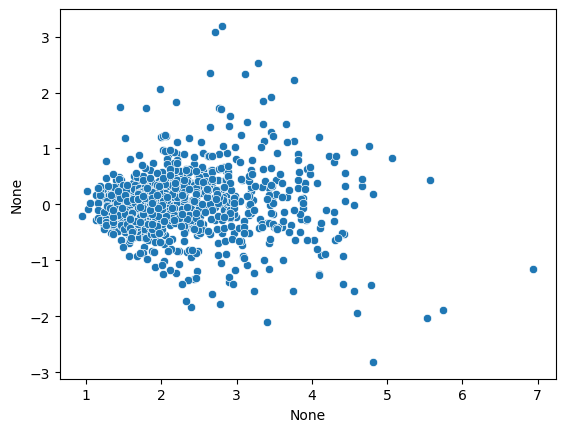

In [31]:
# u_hat vs price
sns.scatterplot(x=predicted, y=resid, data=df) # fill in the blanks


<Axes: xlabel='None', ylabel='None'>

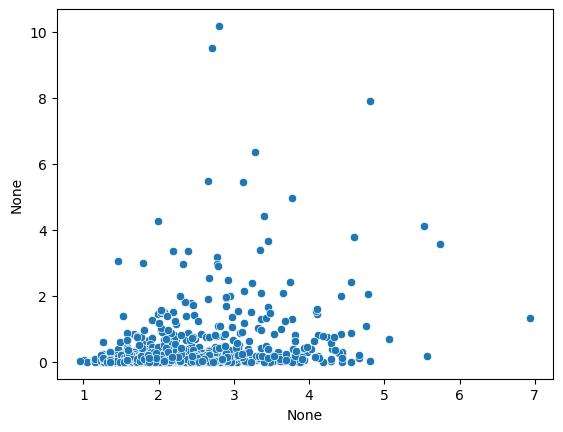

In [30]:
# u_hat^2 vs price
resid2 = resid**2

sns.scatterplot(x=predicted, y=resid2, data=df) # fill in the blanks

<Axes: xlabel='m2', ylabel='None'>

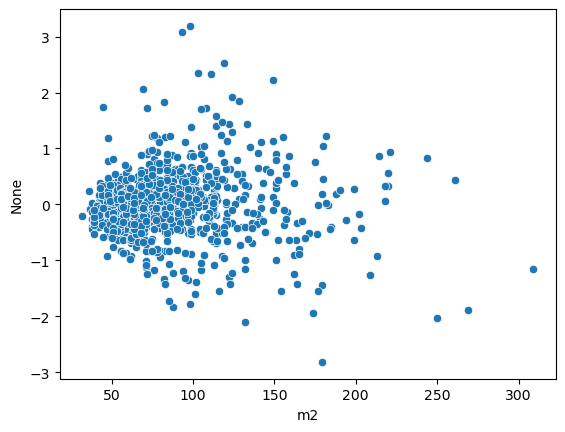

In [32]:
# u_hat vs m2
sns.scatterplot(x=df.m2, y=resid, data=df) # fill in the blanks

<Axes: xlabel='m2', ylabel='None'>

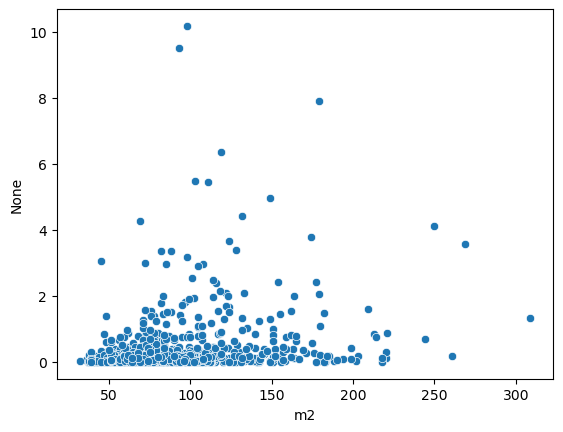

In [33]:
# u_hat^2 vs m2
sns.scatterplot(x=df.m2, y=resid2, data=df) # fill in the blanks

Do the graphs suggest that heteroskedasticity is present? If yes, what type of heteroskedasticity do you find?

**Your answer**

De indeholder alle heteroskedacitet, i form af at de stager i takt med x. 


#### Task 3.
Perform the Breusch-Pagan test for heteroskedasticity by regressing $\hat{u}_i^2$ against the right-hand side variables of model (2). Write up the null and alternative hypotheses. Calculate both the $F$ and $LM$ test statistics. Are there signs of heteroskedasticity?


**Your code:**

In [40]:
# Regresser u_hat^2 på højresiden af model (2)
#H_0: m2 = m2_2 = rooms = toilets = 0

model3 = smf.ols('resid2 ~ C(location) + m2 + m2_2 + rooms + toilets', data=df).fit(cov='HC1')
print(model3.summary())


                            OLS Regression Results                            
Dep. Variable:                 resid2   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     15.16
Date:                Fri, 11 Oct 2024   Prob (F-statistic):           6.58e-19
Time:                        08:57:41   Log-Likelihood:                -1154.2
No. Observations:                 988   AIC:                             2324.
Df Residuals:                     980   BIC:                             2364.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0834 

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=21.833041286980006, p=2.803782042986498e-17, df_denom=980, df_num=4>

In [53]:
# Beregn LM-test
#0.098*988=96.824
import scipy

scipy.stats.chi.ppf(0.95,7)

3.7506186755440982

Man skal gange med $R^2$ n og så sammenligne med kritisk værdi. Vi ser at 96.824>3.75 så vi forkaster. 

In [43]:
# Beregn F-test
hypotese = 'm2 = m2_2 = C(location)[T.KBH N] = C(location)[T.KBH O] = C(location)[T.KBH V] = rooms = toilets = 0'
model3.f_test(hypotese)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=15.16446248920297, p=6.575110762711485e-19, df_denom=980, df_num=7>

**Your answer:**

Forkaster med et brag, at der er homoskedacitet. 



#### Task 4.
Perform a specific Breusch-Pagan test for heteroskedasticity assuming that apartment size is the most likely cause of heteroskedasticity. Perform the test by regressing $\hat{u}_i^2$ against $m2$ and a constant. Write up the null and alternative hypotheses. Calculate a relevant test statistic. What do you conclude?


**Your code:**

In [ ]:
# Regresser u_hat^2 på m2 og aflæs t-værdi


**Your answer:**



#### Task 5.
Suppose that the variance of the error term in model (2) is:

$$
\text{Var}(u_i | X) = \sigma^2 h(X) = \sigma^2 m2_i
$$

where $h(X) = m2_i$. Does this type of heteroskedasticity correspond to your previous finding? Estimate model (2) using the Weighted Least Squares (WLS) estimator.

Make sure you understand both the hint below before you proceed.




_Hint:_ 

You can use the built-in `.wls()` function in statsmodels to estimate the model with the WLS estimator. If you named your dataframe `df` and your squared m2 `m2sq`, you can use the code:

```py
smf.wls('price ~ C(location) + m2 + m2sq + rooms + toilets', weights=1/df.m2, data=df)
```
Note that statsmodels' weight-option defines weights, $w$, that are equivalent to the inverse of Wooldridge's $h$-function. That is, $w=1/h$.



Compare the WLS estimates with the OLS estimates from question 1. Which set of estimates is consistent? Which set of estimates is efficient (meaning having the smallest variance)?


**Your code:**

In [ ]:
model = smf.wls(formula=..., weights=..., data=...) # fill in the blanks
results = model.fit()
print(results.summary())

**Your answer:**



#### Task 6.
Calculate the WLS estimates manually by dividing all the variables in model (2) by $\sqrt{h(X)} = \sqrt{m2_i}$. 

Make sure you understand both hints below before you proceed.



_Hint 1:_

First of all, we need to manually generate the location dummy variables (we can't use statsmodels' built-in method to generate dummies as previously when we need the transformed versions)

```py
df['KbhN'] = (df.location == 'KBH N')
df['KbhO'] = (df.location == 'KBH O')
df['KbhV'] = (df.location == 'KBH V')
```

Now, to divide all the variables in model (2) by $\sqrt{m2_i}$, you can use this code:

```py
df['w'] = 1/np.sqrt(df.m2) # add the weights as a variable to the dataframe
vars = ['price', 'KbhN', 'KbhO', 'KbhV', 
        'm2', 'm2sq', 'rooms', 'toilets'] # list of variables to be transformed

for var in vars:
    df[f'{var}star'] = df[var] * df.w # Multiply each variable in the list by the weight
```

You can now compute the WLS estimate using OLS with the transformed variables.


_Hint 2_: The intercept in the transformed model will be equal to $1/\sqrt{m2_i}$ and not a constant. For this reason, you have to include the weights $w_i = 1/\sqrt{m2_i}$ as an additional regressor and exclude the constant term. Statsmodels will exclude the automatic constant term if you add `- 1` to your model formula:

```py
formula = 'pricestar ~ KbhNstar + ... + w - 1' 
```



Are you able to replicate the results from question 5?



**Your code:**

**Your answer:**


#### Task 7.
The OLS estimator is unbiased under MLR.1–MLR.4, but without MLR.5, standard inference is not valid. In the presence of heteroskedasticity, it is however possible to calculate robust standard errors, robust $t$ test statistics, and robust Wald/$F$ test statistics.

Estimate model (2) using OLS with robust standard errors.



_Hint:_ 

To use the robust variance estimator in statsmodels,  use the `.get_robustcov_results()` method of your OLS results object. So wherever you used `results` before, now use `results.get_robustcov_results()`

Alternatively, when estimating your model, you can use `.fit(cov_type='HC1')` instead of just `.fit()`. This is easier in the long run.

If you're wondering what 'HC1' means, it's the name of the specific variant of the robust covariance matrix used. There are multiple alternative versions available. If you are _really_ interested, you can read more here: https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLSResults.html#statsmodels.regression.linear_model.OLSResults

_Extra hint:_ When using Statsmodels to run OLS regressions using robust standard errors, Statsmodels will per default report z-statistics instead of the usual t-statistics. If you want to prevent this, you can add the argument `use_t=True` to the `.fit()` method. But in this case, the two statistics are identical.

**Your code:**

Now test the two hypotheses of $\delta_3 = 0$ and $\beta_3 = \beta_4 = 0$ using the robust variance estimator. Explain what the relevant alternative hypotheses are and calculate the relevant test statistics. What do you conclude? 

**Your code:**

**Your answer:**


#### Task 8.
Calculate the Breusch-Pagan test for the original model (1), where the dependent variable is $\log(\text{prices})$. Are there signs of heteroskedasticity?


**Your code:**

**Your answer:**